# Описание проекта:

Необходимо проанализировать данные развлекательного приложения Procrastinate Pro+: несколько прошлых месяцев бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Нужно разобраться в причинах этой ситуации.

Цель исследования - повысить эффективность затрат на маркетинг.

**План исследования:**

*Шаг 1. Загрузка и подготовка данных к анализу*

*Шаг 2. Написание функций для расчета и анализа LTV, ROI, удержания и конверсии*

*Шаг 3. Исследовательский анализ данных*

Построить профилей пользователей. Определить минимальную и максимальную даты привлечения пользователей.
Опрелить, из каких стран приходят пользователи, какими утройствами они пользуются, из каких рекламных каналов приходят. Посмотреть по каждой разбивке, как распрделились доли платящих пользователей.

*Шаг 4. Маркетинг*

Определить общие расходы на маркетинг. Посмотреть общие расходы и расходы на каждый источник в динамике.
Рассчитать общий САС, САС на одного покупателя по каждому источнику трафика.

*Шаг 5. Оценка окупаемости рекламы*

Определить общую окупаемость рекламы. Посмотреть окупаемость рекламы в разбивке по утройствам, странам и рекламным каналам.

*Шаг 6. Выводы и рекомендации*


**Описание данных:**

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

# Шаг 1. Загрузка и подготовка данных к анализу

In [1]:
#импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date, datetime, timedelta
import seaborn as sns

In [2]:
visits = pd.read_csv('downloads/visits_info_short.csv')
orders = pd.read_csv('downloads/orders_info_short.csv')
costs = pd.read_csv('downloads/costs_info_short.csv')

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [5]:
#переведем названия столбцов в более удобный для использования вид:
visits.columns = visits.columns.str.lower()
visits.rename(columns={
    'user id': 'user_id', 
    'session start':'session_start', 
    'session end':'session_end'}, inplace=True)

In [6]:
#преобразуем даты:
visits['session_start'] = pd.to_datetime(visits['session_start'], format='%Y-%m-%d %H:%M:%S')
visits['session_end'] = pd.to_datetime(visits['session_end'], format='%Y-%m-%d %H:%M:%S')

In [7]:
#преобразуем названия регионов, устройств и источников привлечения пользователей в строки:
visits['region'] = visits['region'].astype(str)
visits['device'] = visits['device'].astype(str)
visits['channel'] = visits['channel'].astype(str)

In [8]:
#проверим наличие дубликатов:
visits[visits.duplicated()]

,user_id,region,device,channel,session_start,session_end


Дубликатов в таблице о визитах нет.

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [10]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [11]:
#переведем названия столбцов в более удобный для использования вид:
orders.columns = orders.columns.str.lower()
orders.rename(columns={
    'user id': 'user_id', 
    'event dt':'event_dt'}, inplace=True)

In [12]:
#переведем дату и время в нужный формат:
orders['event_dt'] = pd.to_datetime(orders['event_dt'], format='%Y-%m-%d %H:%M:%S')

In [13]:
#проверим наличие дубликатов:
orders[orders.duplicated()]

,user_id,event_dt,revenue


Дубликатов в таблице с заказами тоже нет.

In [14]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [15]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [16]:
#переведем названия столбцов в более удобный для использования вид:
costs.columns = costs.columns.str.lower()

In [17]:
#отформатирупем даты:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

In [18]:
#переведем названия каналов в строковый тип:
costs['channel'] = costs['channel'].astype('str')

In [19]:
#проверим наличие дубликатов:
costs[costs.duplicated()]

,dt,channel,costs


Дубликатов в таблице со стоимостью рекламы нет.

В ходе исследования были рассмотрены 3 файла. В каждом из них названия столбцов были приведены к нижнему регистру, столбцы с датой и временем переведены в соответстьвующий тип.

# Шаг 2. Написание функций для расчета и анализа LTV, ROI, удержания и конверсии

In [20]:
# функция для создания пользовательских профилей
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [21]:
# функция для расчёта удержания
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [22]:
# функция для визуализации удержания
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [23]:
# функция для расчёта конверсии
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


In [24]:
# функция для визуализации конверсии
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [25]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [26]:
# функция для сглаживания фрейма
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [27]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [28]:
#зададим момент и горизонт анализа:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

# Шаг 3. Исследовательский анализ данных

### Составим профили пользователей

In [29]:
# получим профили пользователей:
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5)) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [30]:
#определим минимальную и максимальную даты привлечения пользователей:
min_analysis_date = profiles['dt'].min()
observation_date = profiles['dt'].max()

display('Минимальная дата привлечения:', min_analysis_date) 
display('Максимальная дата привлечения:', observation_date)

'Минимальная дата привлечения:'

Timestamp('2019-05-01 00:00:00')

'Максимальная дата привлечения:'

Timestamp('2019-10-27 00:00:00')

In [31]:
#напишем функцию для создания таблиц с количеством пользователей и долей плательщиков:
def pivot_ratio_result(column, df):
    result = pd.DataFrame()
    result['users_count'] = df.groupby(column)['user_id'].count()
    result['users_ratio'] = ((result['users_count'] / df[column].count()) * 100)
    result['payers_count'] = df.query('payer == True').groupby(column)['user_id'].count()
    result['payers_ratio'] = ((result['payers_count'] / result['users_count']) * 100)
    return result.sort_values(by='payers_ratio', ascending=False).style.format({'users_ratio': '{:.2f}%', 
                                                                               'payers_ratio': '{:.2f}%'})

### Выясним, из каких стран приходят пользователи

In [32]:
#составим таблицу с количеством пользователей и долей плательщиков по каждой стране:
pivot_ratio_result('region', profiles)

,users_count,users_ratio,payers_count,payers_ratio
region,,,,
United States,100002,66.66%,6902,6.90%
Germany,14981,9.99%,616,4.11%
UK,17575,11.72%,700,3.98%
France,17450,11.63%,663,3.80%


Пользователи приходят из 4 регионов: США, Англии, Франции и Германии. Большая часть пользователей приходится на Америку (66,66% от общего числа), меньше всего человек привлечено из Германии (чуть меньше 10% от общего числа). Доли платящих пользователей распределились немного иначе: больше всего заказов было из США(6,9%, или 6902 из 100002 человек), на втором месте - Германия(4,11%, или 616 из 14981 человек), далее идут Англия(3,98%, или 700 человек из 17575) и на последнем месте Франция(3,8%, или 663 человека из 17450).

### Выясним, какими устройствами пользуются клиенты

In [33]:
#составим таблицу с количеством пользователей и долей плательщиков по каждому устройству:
pivot_ratio_result('device', profiles)

,users_count,users_ratio,payers_count,payers_ratio
device,,,,
Mac,30042,20.03%,1912,6.36%
iPhone,54479,36.32%,3382,6.21%
Android,35032,23.35%,2050,5.85%
PC,30455,20.30%,1537,5.05%


Клиенты пользуются как мобильными телефонами, так и компьютерами. Доля пользоватей мобильных устройств больше: лидируют владельцы Iphone (36,32% от всех пользователей), на втором месте - владельцы Android (23,35%). Доли пользователей PC и Mac распределились почти поровну - 20,3% использовали PC и 20,03% - Мас.

Доли платящих пользователей при этом распределились по-другому: больше всего плательщиков среди пользователей Мас (6,36%) и Iphone (6,21%). Доли плательщиков среди пользователей Android и PC меньше - 5,85% и 5,05% соотвесттвенно.

### Выясним, из каких рекламных источников приходили пользователи

In [34]:
#изучим источники привлечения пользователей:
pivot_ratio_result('channel', profiles)

,users_count,users_ratio,payers_count,payers_ratio
channel,,,,
FaceBoom,29144,19.43%,3557,12.20%
AdNonSense,3880,2.59%,440,11.34%
lambdaMediaAds,2149,1.43%,225,10.47%
TipTop,19561,13.04%,1878,9.60%
RocketSuperAds,4448,2.97%,352,7.91%
WahooNetBanner,8553,5.70%,453,5.30%
YRabbit,4312,2.87%,165,3.83%
MediaTornado,4364,2.91%,156,3.57%
LeapBob,8553,5.70%,262,3.06%


Довольно много пользователей пришло в приложение самостоятельно: на органический трафик приходится 37,62% человек от общего количества.
Среди платного трафика есть два лидера: FaceBoom(19,43% пользователей) и TipTop(13,04% пользователей).

Доли платящих пользователей распределились по-другому: лидирует FaceBoom(12,2% из 29144 человек совершили покупку), затем AdNonSense(11,34% из 3880 человек совершили покупку) и lambdaMediaAds(10,47% из 2149 человек совершили покупку). 

Доля платящих пользователей для органического трафика очень мала: покупку совершили всего 2% клиентов из всех, кто пришел в приложение самостоятельно. Этот канал конвертируется хуже всего.

### Вывод

Пользователи приходят из 4 регионов: США, Англии, Франции и Германии. Большая часть пользователей приходится на Америку (66,66% от общего числа), меньше всего человек привлечено из Германии (чуть меньше 10% от общего числа). Доли платящих пользователей распределились немного иначе: больше всего заказов было из США(6,9%, или 6902 из 100002 человек), на втором месте - Германия(4,11%, или 616 из 14981 человек), далее идут Англия(3,98%, или 700 человек из 17575) и на последнем месте Франция(3,8%, или 663 человека из 17450).

Клиенты пользуются как мобильными телефонами, так и компьютерами. Доля пользоватей мобильных устройств больше: лидируют владельцы Iphone (36,32% от всех пользователей), на втором месте - владельцы Android (23,35%). Доли пользователей PC и Mac распределились почти поровну - 20,3% использовали PC и 20,03% - Мас. Доли платящих пользователей при этом распределились по-другому: больше всего плательщиков среди пользователей Мас (6,36%) и Iphone (6,21%). Доли плательщиков среди пользователей Android и PC меньше - 5,85% и 5,05% соотвесттвенно.

Довольно много пользователей пришло в приложение самостоятельно: на органический трафик приходится 37,62% человек от общего количества. Среди платного трафика есть два лидера: FaceBoom(19,43% пользователей) и TipTop(13,04% пользователей). Доли платящих пользователей распределились по-другому: лидирует FaceBoom(12,2% из 29144 человек совершили покупку), затем AdNonSense(11,34% из 3880 человек совершили покупку) и lambdaMediaAds(10,47% из 2149 человек совершили покупку). 

Доля платящих пользователей для органического трафика очень мала: покупку совершили всего 2% клиентов из всех, кто пришел в приложение самостоятельно. Этот канал конвертируется хуже всего.

# Шаг 4. Маркетинг

In [35]:
#посчитаем общие затраты на маркетинг:
display(costs['costs'].sum())

105497.30000000002

Всего на рекламу было потрачено 105497.3$.

In [36]:
#рассчитаем затраты на каждый источник:
channel_costs_report = pd.DataFrame()
channel_costs_report['costs'] = costs.groupby('channel')['costs'].sum()
channel_costs_report['ratio'] = ((channel_costs_report['costs'] / costs['costs'].sum()) * 100)
channel_costs_report.sort_values(by='ratio', 
                                 ascending=False).style.format({'ratio': '{:.2f}%'})

,costs,ratio
channel,,
TipTop,54751.300000,51.90%
FaceBoom,32445.600000,30.75%
WahooNetBanner,5151.000000,4.88%
AdNonSense,3911.250000,3.71%
OppleCreativeMedia,2151.250000,2.04%
RocketSuperAds,1833.000000,1.74%
LeapBob,1797.600000,1.70%
lambdaMediaAds,1557.600000,1.48%
MediaTornado,954.480000,0.90%


51,9% затрат на рекламу приходится на TipTop. Более 30% - на FaceBoom. Затраты на остальные источники в разы меньше и составляют менее 5% от общей суммы.

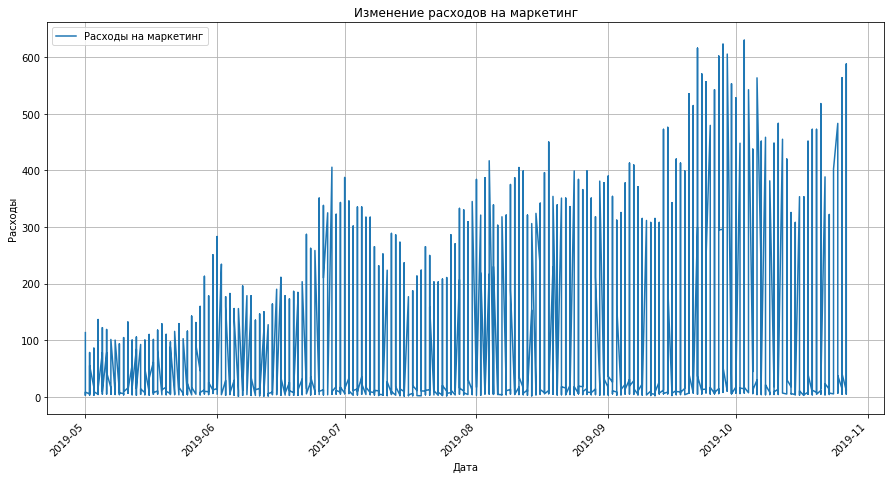

In [37]:
#изучим, как менялись общие затраты на маркетинг:
costs.plot(y='costs',
           x='dt',
           figsize=(15, 8),
           grid=True,
           rot=45,        
           label='Расходы на маркетинг',                     
           legend=True) 

plt.title('Изменение расходов на маркетинг')
plt.xlabel('Дата')
plt.ylabel('Расходы')
plt.show()

По графику видно, что расходы на маркетинг постоянно росли.

In [38]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

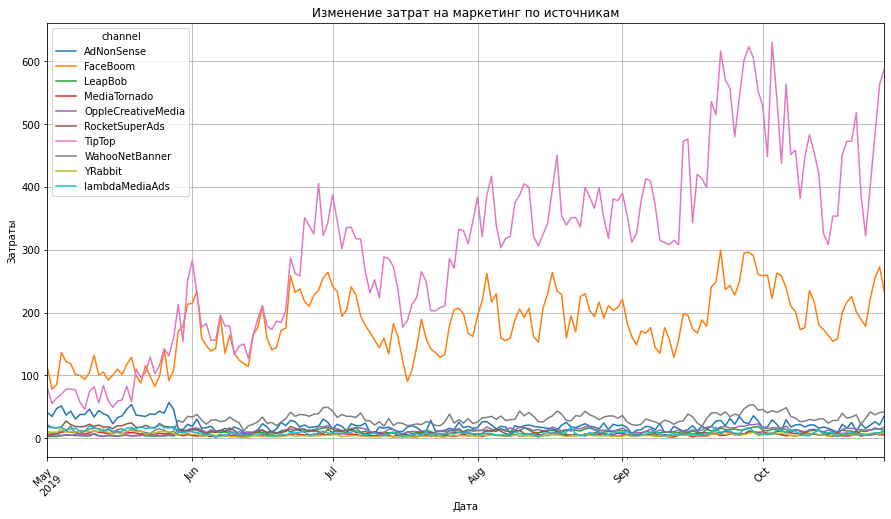

In [39]:
#построим график изменения затрат на маркетинг по каждому источнику:
filtered_data = costs.pivot_table(
        index='dt', columns='channel', values='costs', aggfunc='sum'
    )
filtered_data.plot(                                             
           figsize=(15, 8),
           grid=True,
           rot=45,        
           label='Каналы',                      
           legend=True
) 

plt.title('Изменение затрат на маркетинг по источникам')
plt.xlabel('Дата')
plt.ylabel('Затраты')
plt.show()

На графике видно увеличение затрат на FaceBoom и TipTop. 
Причем с Faceboom начинали с большим бюджетом - около 100-125 долларов в день в  начале  мая. 
Далее затраты на этот источник повысились и в основном находились в дапазоне 150-250 долларов в день, а на пике достигали 300 долларов в день. 
Начиная с июня, затраты на этот источник оставались довольно равномерными.

Рекламу в TipTop начинали с дневным бюджетом 50-75 долларов в день, а затем его периодически повышали в течение всего исследуемого периода. 
На пике затраты на этот источник составляли 625 долларов в день.

Затраты на остальные источники трафика обычно были не выше 50 долларов в день, и в целом они выглядят равномерно. 
Заметно снижение завтрат в AdNonSence к июню с 35-50 долларов в день до приблизительно 20-25 долларов в день, а также увеличение затрат на WahooNetBanner в тот же период.

In [40]:
#рассчитаем средний САС на одного пользователя:
profiles = profiles.query('channel!="organic"')
profiles['acquisition_cost'].describe()

count    93569.000000
mean         1.127481
std          0.990503
min          0.124615
25%          0.257143
50%          1.080531
75%          1.128571
max          3.715385
Name: acquisition_cost, dtype: float64

Средняя стоимость привлечения покупателя - примерно 1.12 долларов, при этом медиана - 1.08.

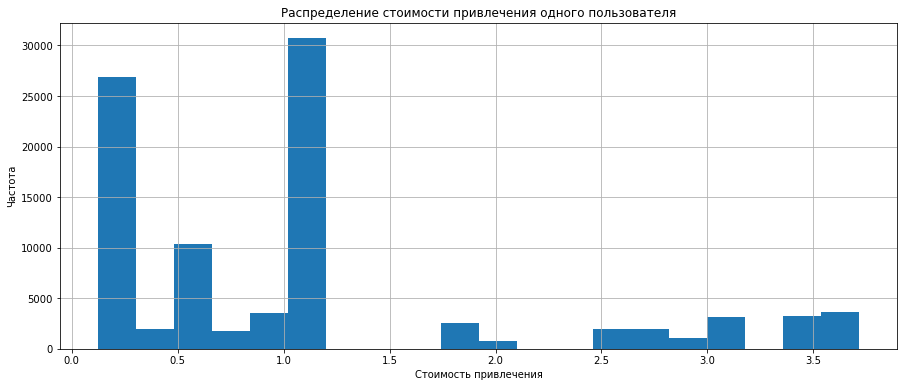

In [41]:
#посмотрим распределение стоимости привлечения одного пользователя:
profiles['acquisition_cost'].hist(bins=20, figsize=(15, 6))
plt.title('Распределение стоимости привлечения одного пользователя')
plt.xlabel('Стоимость привлечения')
plt.ylabel('Частота')
plt.show()

Из гистограммы видно, что большинство привлеченных пользователей являются довольно "дешевыми", но есть и ряд "дорогих", САС у которых составляет 2,5 доллара и выше.

In [42]:
#рассчитаем САС для каждого источника трафика:
cac_by_channel = pd.DataFrame()
cac_by_channel['acquisition_cost_mean'] = profiles.groupby('channel')['acquisition_cost'].mean()
cac_by_channel.sort_values(by='acquisition_cost_mean', 
                           ascending=False).style.format({'acquisition_cost_mean': '{:.2f}'})

,acquisition_cost_mean
channel,
TipTop,2.80
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.72
WahooNetBanner,0.60
RocketSuperAds,0.41
OppleCreativeMedia,0.25
YRabbit,0.22
MediaTornado,0.22


Самые "дорогие" пользователи - в источнике TipTop. Средняя стоимость их привлечения составляет 2,8 доллара, что на порядок выше среднего значения по всем источникам.

Стоимость привлечения пользователя в каналах FaceBoom и AdNonSense находится в районе среднего значения и составляет 1.11 и 1.01 доллара.

В остальных источниках пользователи получаются довольно "дешевыми", а пользователи из органического трафика бесплатные.

**Вывод**

Всего на рекламу было потрачено 105497.3 доллара.

51,9% затрат на рекламу приходится на TipTop. Более 30% - на FaceBoom. Затраты на остальные источники составляют менее 5% от общей суммы.

Средняя стоимость привлечения покупателя - примерно 1.12 долларов.

Затраты на FaceBoom и TipTop увеличивались со временем, достигая пика в 300 и 625 долларов в день соотвественно. Затраты на остальные источники трафика были намного меньше и обычно были не больше 50 долларов в день.

Самые "дорогие" пользователи - в источнике TipTop. Средняя стоимость их привлечения составляет 2,8 доллара, что на порядок выше среднего значения по всем источникам. В каналах FaceBoom и AdNonSense САС находится в районе среднего и составляет 1.11 и 1.01 доллара. В остальных источниках пользователи получаются довольно "дешевыми".

# Шаг 5. Оценка окупаемости рекламы

С помощью LTV и ROI:
- Проанализируйте общую окупаемость рекламы;
- Проанализируйте окупаемость рекламы с разбивкой по устройствам;
- Проанализируйте окупаемость рекламы с разбивкой по странам;
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. При решении этого шага считайте, что вы смотрите данные 1-го ноября 2019 года и что в вашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей.

### Проанализируйте общую окупаемость рекламы

In [43]:
#исключим пользователей с органическим трафиком, т.к. он не имеет отношения к затратам на маркетинг:
profiles = profiles.query('channel!="organic"')

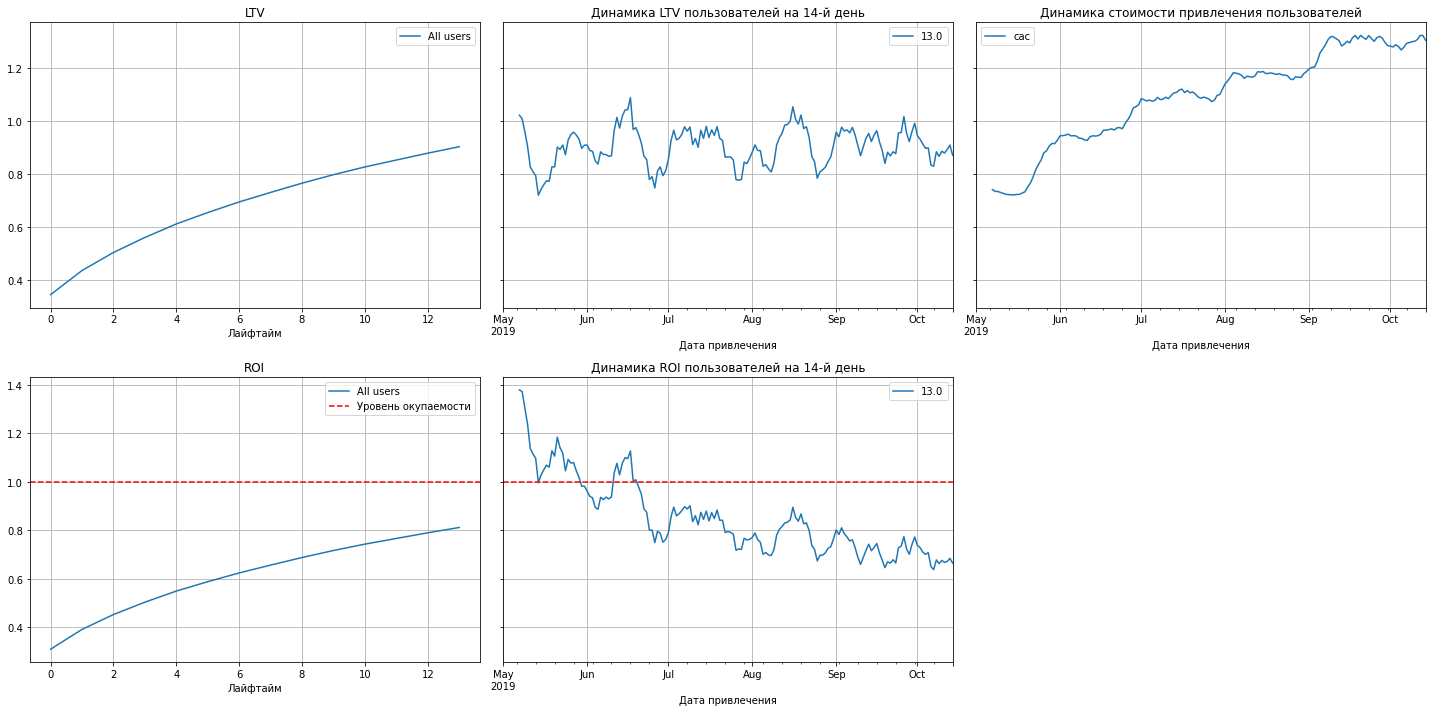

In [44]:
#расчитаем LTV и ROI:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

#построим графики:
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Из графиков видно, что затраты на рекламу не окупаются. LTV в целом стабилен, значит, дело не в ухудшении качества пользователей.
CAC растет - это значит, что затраты на рекламу увеличиваются со временем. ROI падает: в июне реклама в целом окупалась, но потом вышла в минус, и ROI продолжил падать.

### Проанализируйте окупаемость рекламы с разбивкой по устройствам

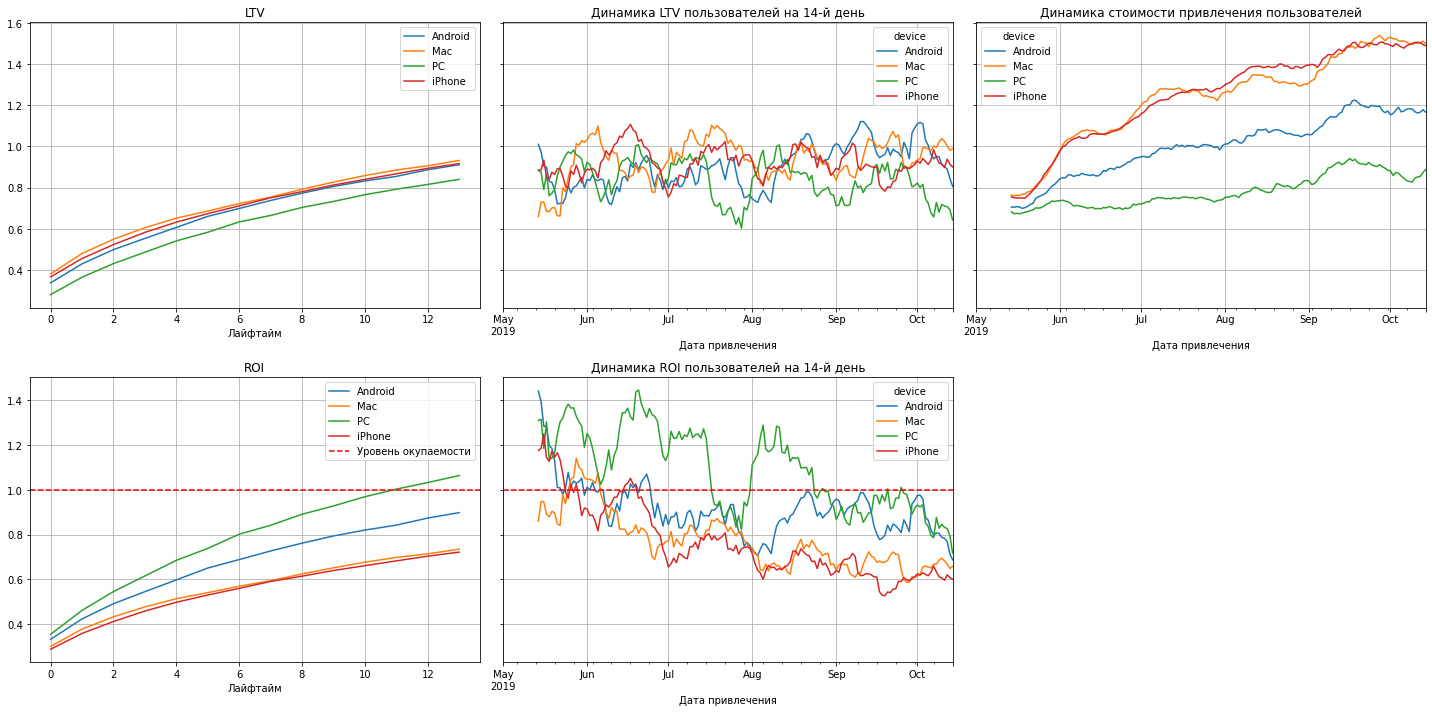

In [45]:
#рассмотрим окупаемость рекламы по устройствам:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Из графиков видно, что LTV в целом стабилен для всех устроийств. САС растет для всех устройств, но в разной степени: сильно увеличилась стоимость привлечения пользователей Iphone и Mac, намного меньше увеличение стоимости для владельецев Android и еще меньше - для владельцев PC.
Лучше всего окупаются пользователи PC(эта категория единственная, которая вышла на уровень окупаемости к концу лайфтайма), хуже - Iphone и Mac.

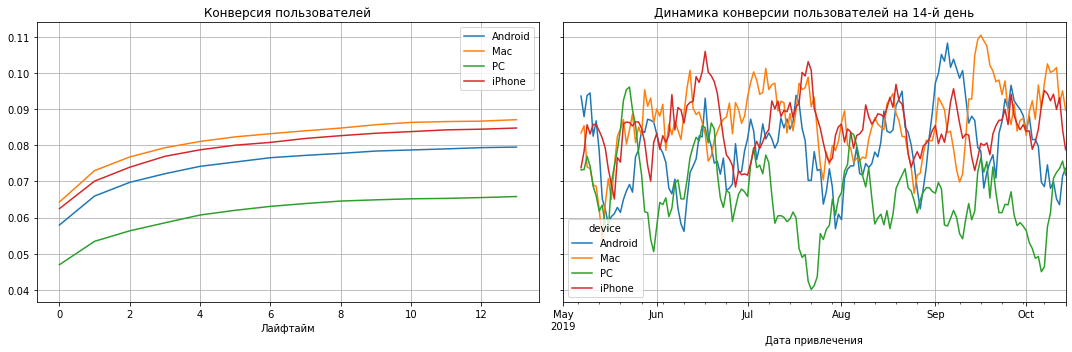

In [46]:
#рассмотрим конверсию по устройствам:
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Пользователи Mac и Iphone конвертируются лучше пользователей Android и PC. Наименьшая конверсия у пользователей PC.

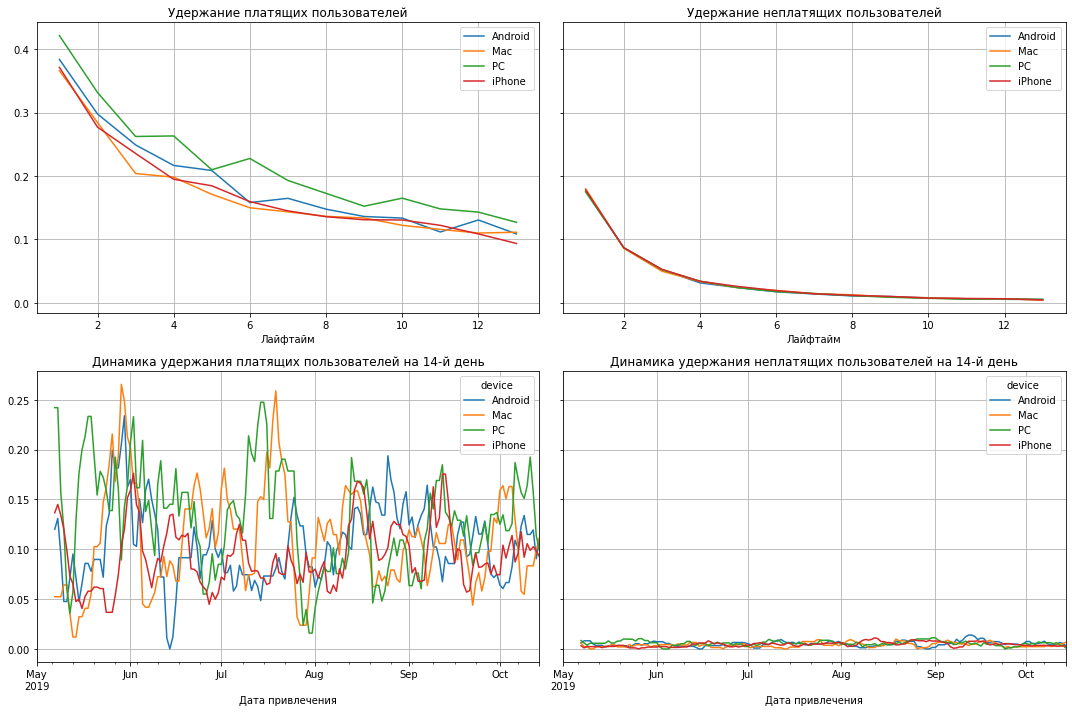

In [47]:
#рассмотрим удержание по устройствам:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Платящие пользователи удерживаются лучше неплатящих. Удержание неплатящих пользователей довольно быстро начинает стремиться к нулю, а среди платящих лучше всего удерживаются пользователи PC.

### Проанализируйте окупаемость рекламы с разбивкой по странам

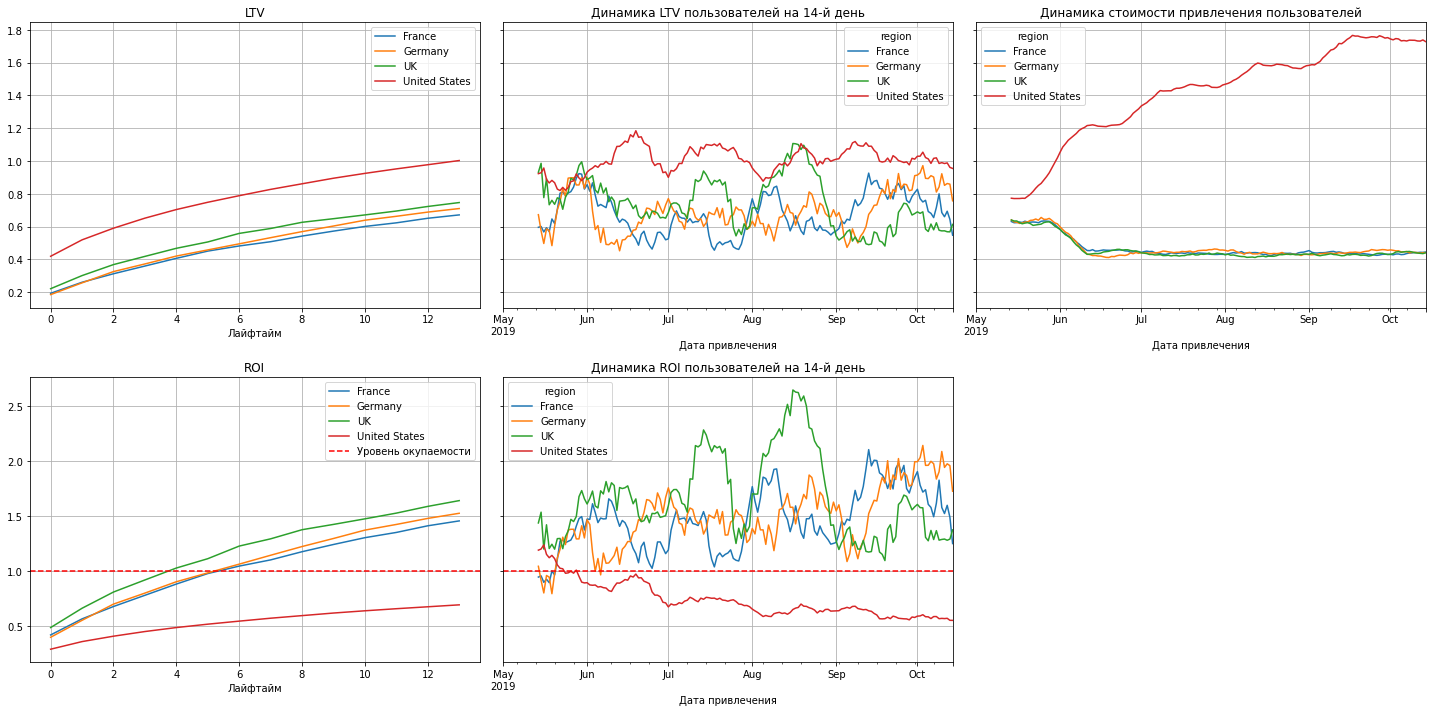

In [48]:
#рассмотрим окупаемость рекламы по странам:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Реклама окупается в 3 странах: Франции, Германии и Англии. Реклама в США не окупается. При этом САС для пользователей из стран, где реклама окупилась, намного ниже, чем САС для пользователей США.

ROI для пользователей США был выше окупаемости в мае и большей части июня, но потом опустился ниже и продолжил падать, в отличие от ROI по остальным странам.

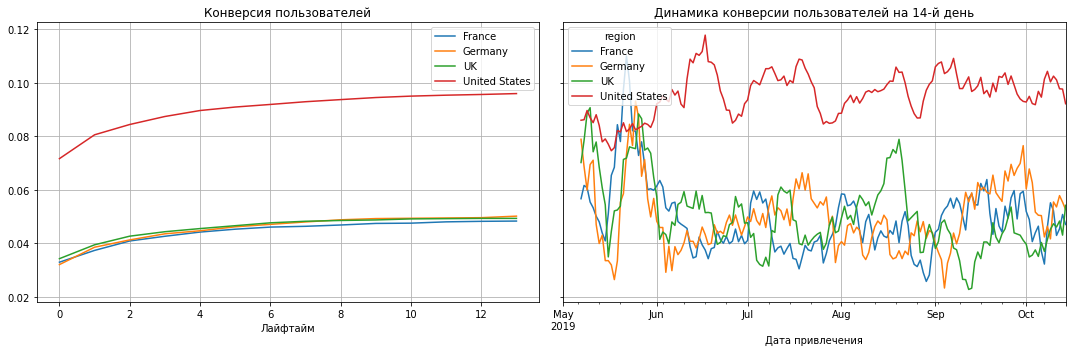

In [49]:
#рассмотрим конверсию по странам:

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Несмотря на то, что реклама в США не окупается, конверсия в этом регионе на порядок выше, чем в остальных трех. Хуже всего конвертируется Франция.

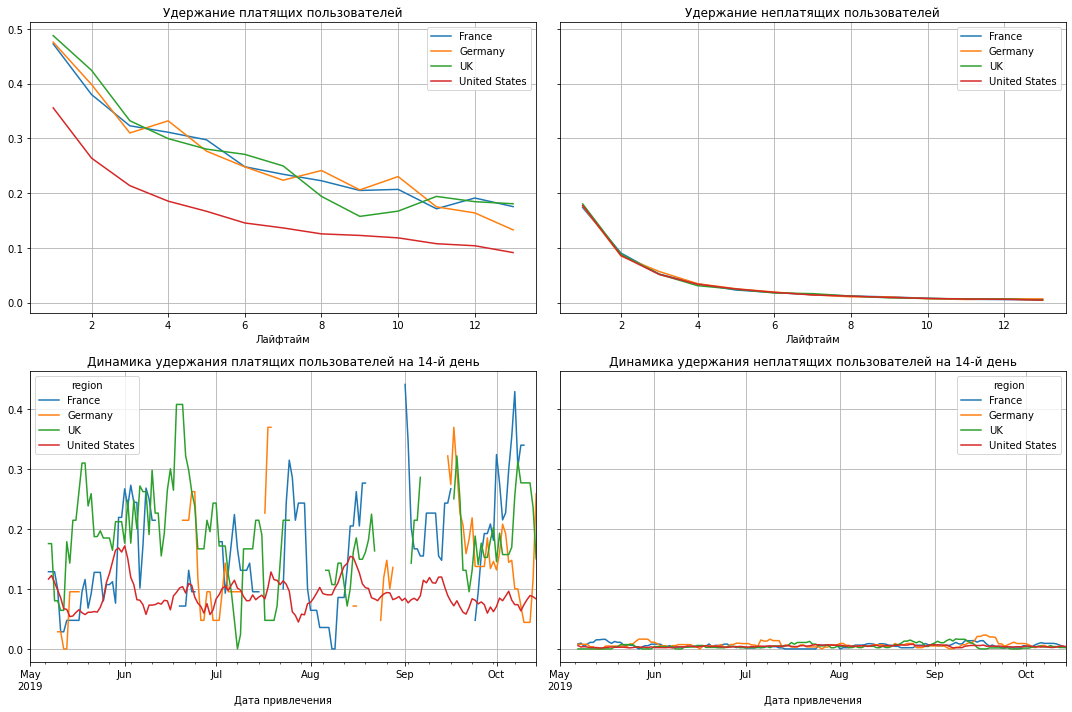

In [50]:
#рассмотрим удержание по странам:

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Платящие пользователи также ужерживаются лучше неплатящих. Но среди платящих хуже всего удерживаются пользователи из США.

### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

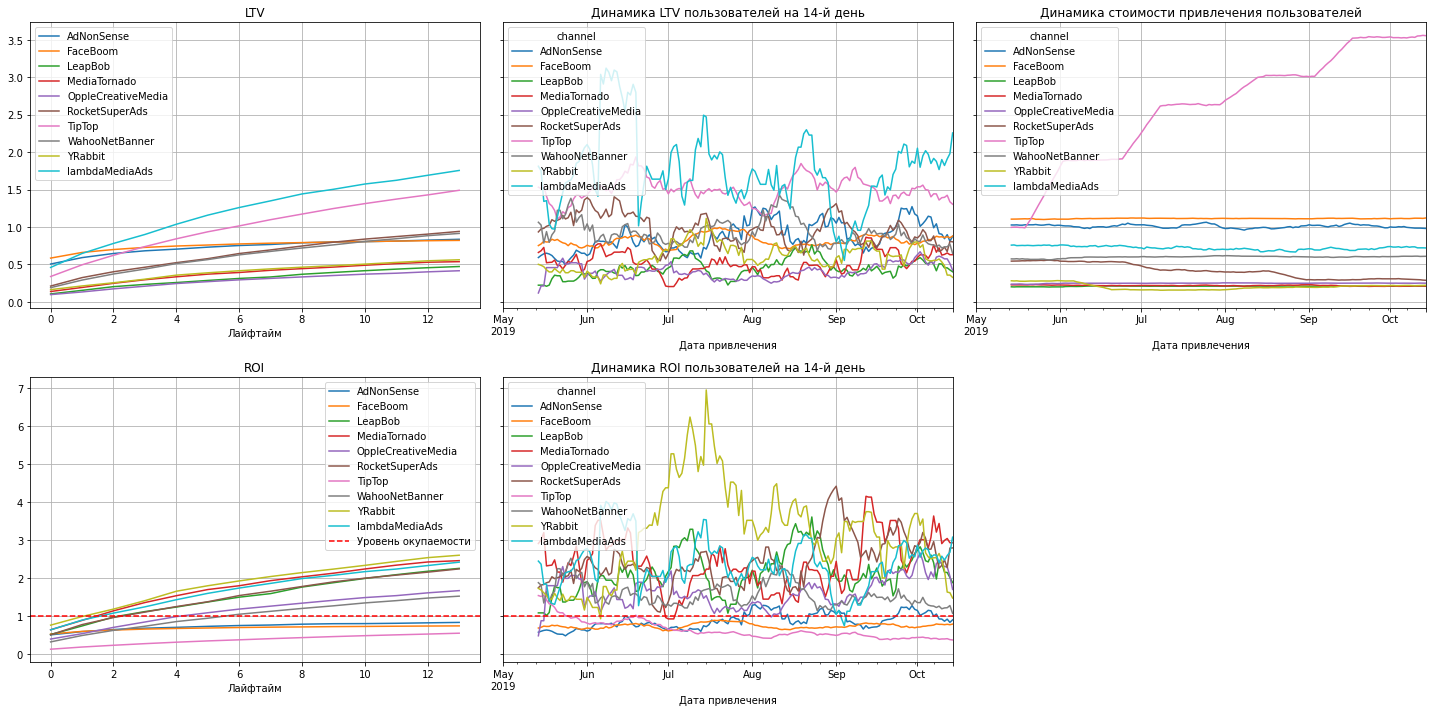

In [55]:
#рассмотрим окупаемость рекламы по источникам привлечения пользователей:

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Реклама не окупается для трех истоников: AdNonSence, FaceBoom и TipTop. При этом стоимость привлечения в TipTop становится все выше и выше, а для остальных источников САС практически стабилен.
Показатели ROI на 14 день у источника Yrabbit лучше других источников, особенно это заметно в период с серединыы июня по середину августа. Также неплохо показывают себя MediaTornado и RocketSuperAds(кроме всего прочего, у последнего наблюдается снижение САС).

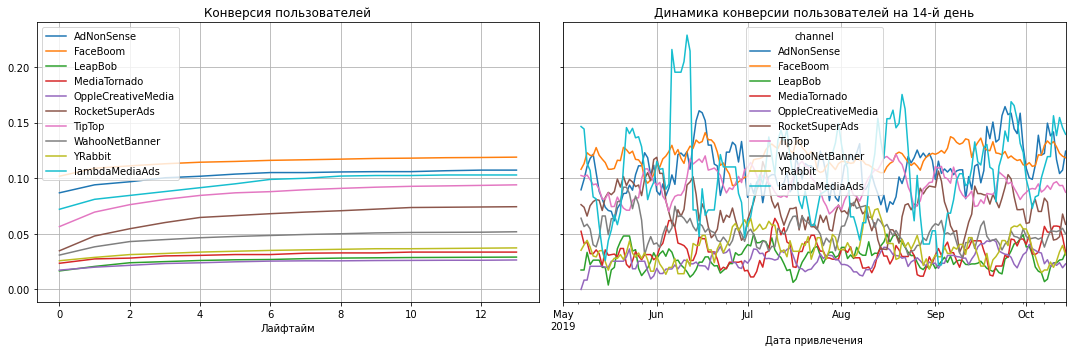

In [56]:
#рассмотрим конверсию по каналам:

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Лучше всего конвертируются пользователи, привлеченные из FaceBoom, хуже всего - из OppleCreativeMedia, LeapBob, MediaTornado и Yrabbit.

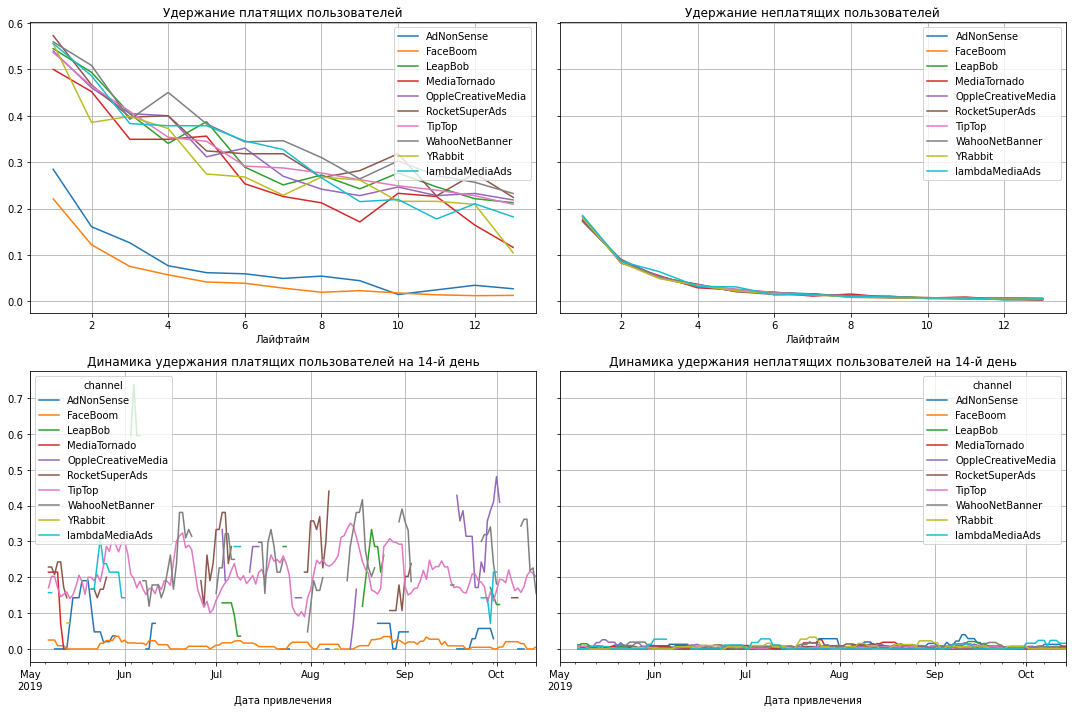

In [57]:
#рассмотрим удержание по каналам:

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание платящих пользователей примерно одинаково для всех источников трафика, кроме двух: AdNonSense и FaceBoom. В этих двух источниках удержание заметно хуже, чем в остальных.

**Вывод**

Реклама довольно близка к окупаемости, т.к. ROI к концу второй недели становится выше 80%.

Окупаемость ухудшают следующие показатели:
* по пользователям Iphone и Mac - для них стоимость привлечения пользователя больше, чем для пользователей остальных устройств
* по странам, а именно США: доля привлеченных пользователей отсюда самая большая, а вот стоимость привлечения пользователя намного выше, чем в других странах. Удержание для пользователей США также хуже, чем для пользователей остальных стран. Также США - единственная страна, реклама в которой не окупается.
* по источникам привлечения пользователей: не окупается реклама в AdNonSence, FaceBoom и TipTop. При этом в TipTop очень высокая стоимость привлечения пользователей, а в FaceBoom и AdNonSence удержание заметно хуже остальных источников.

# Шаг 6. Выводы и рекомендации

Пользователи приходят из 4 регионов: США, Англии, Франции и Германии. Большая часть пользователей приходится на Америку, меньше всего человек привлечено из Германии. Больше всего заказов было из США, на втором месте - Германия, далее идет Англия и на последнем месте - Франция.

Доля пользоватей мобильных устройств больше: лидируют владельцы Iphone, на втором месте - владельцы Android. При этом больше всего плательщиков среди пользователей Мас и Iphone.

Довольно много пользователей пришло в приложение самостоятельно: на органический трафик приходится 37,62% человек от общего количества, но этот источник плохо окупается - всего 2% клиентов, пришедших в приложение самостоятельно, совершили покупку. Больше всего покупателей пришло из FaceBoom, AdNonSense и lambdaMediaAds.

51,9% затрат на рекламу приходится на TipTop. Более 30% - на FaceBoom. Затраты на остальные источники составляют менее 5% от общей суммы. Средняя стоимость привлечения покупателя - примерно 0.7 долларов. Затраты на FaceBoom и TipTop увеличивались со временем, достигая пика в 300 и 625 долларов в день соотвественно. Затраты на остальные источники трафика были намного меньше и редко выходили за пределы 50 долларов в день.

Самые "дорогие" пользователи - в источнике TipTop. Средняя стоимость их привлечения составляет 2,8 доллара, что в 4 раза выше среднего значения по всем источникам. Выше среднего и стоимость привлечения пользователя в каналах FaceBoom и AdNonSense - 1.11 и 1.01 доллара. В остальных источниках пользователи получаются довольно "дешевыми".

Однако, реклама довольно близка к окупаемости, т.к. общий ROI к концу второй недели становится выше 80%.

Окупаемость ухудшают следующие показатели:

* по пользователям Iphone и Mac - для них стоимость привлечения пользователя больше, чем для пользователей остальных устройств.
* по странам, а именно США: доля привлеченных пользователей отсюда самая большая, а вот стоимость привлечения пользователя намного выше, чем в других странах. Удержание для пользователей США также хуже, чем для пользователей остальных стран. Кроме того, США - единственная страна, реклама в которой не окупается.
* по источникам привлечения пользователей: не окупается реклама в AdNonSence, FaceBoom и TipTop. При этом в TipTop очень высокая стоимость привлечения пользователей, а в FaceBoom и AdNonSence удержание заметно хуже остальных источников.

**Рекомендации для отдела маркетинга для повышения эффективности**

Необходимо направить внимание на владельцев Mac и iPhone: стоимость их привлечения выше, чем пользователей других устройств, и она продолжает расти со временем. Возможно, стоит сделать какое-то маркетинговое предложение именно для владельцев этих устройств, чтобы они совершали больше покупок в приложении.

Основная часть пользователей приложения из США, но реклама по этой стране не окупается. Также стоимость привлечения пользователя здесь выше, а удержание хуже, чем у пользователей из других стран. Возможно, стоит сделать упор на продвижение во Франции, Германии и Англии - эти страны лучше окупаются.

Следует уменьшить рюкламный бюджет на TipTop: затраты на этот источник составляют более половины всего бюджета, но при этом там самая высокая стоимость привлечения пользователя(и она растет со временем), а реклама в этом источнике так и не вышла на окупаемость. 

Также не окупаются затраты на рекламу в AdNonSence и FaceBoom, к тому же у этих двух каналов плохое удержание прользователей. Нужно уменьшить расходы и на эти источники трафика.

Таким образом, следует перераспределить рекламный бюджет и направить средства на возможно более прибыльные каналы: YRabbit, MediaTornado, lambdaMediaAds, LeapBop, RocketSuperAds, OppleCreativeMedia или WahooNetBanner.